In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, GlobalAveragePooling2D, Input, \
    BatchNormalization, ReLU, Add, Activation, multiply, Reshape, Lambda, Dropout, Concatenate, DepthwiseConv2D
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 假设您的 GPU 有 10GB 显存，设置稍大于 10GB 的显存限制
        memory_limit = 7680  # 以 MB 为单位
        config = tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(gpu, [config])
    except RuntimeError as e:
        print(e)

In [3]:
# 数据增强配置
train_datagen = ImageDataGenerator(rescale=1.0 / 255)  # 应用其他增强参数
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

DATA_PATH = 'RGB_augmented_300_224'
BATCH_SIZE = 16
TARGET_SIZE = (224, 224)
# 训练集数据生成器
train_generator = train_datagen.flow_from_directory(
    fr'D:\Download\MV_Coursework\Coursework\Code\augmented_image\{DATA_PATH}\train',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

# 验证集数据生成器
validation_generator = validation_datagen.flow_from_directory(
    fr'D:\Download\MV_Coursework\Coursework\Code\augmented_image\{DATA_PATH}\validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

# 测试集数据生成器
test_generator = test_datagen.flow_from_directory(
    fr'D:\Download\MV_Coursework\Coursework\Code\augmented_image\{DATA_PATH}\test',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

Found 900 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [4]:
# 示例权重（类别数量需与权重列表长度匹配）
weights = [1.5, 1.5, 1]  # 对应类别0、1和2的权重


def focal_loss_function(weights, gamma=2, eps=1e-7):
    weights = tf.constant(weights, dtype=tf.float32)

    def focal_loss(y_true, y_pred):
        y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], tf.shape(y_pred)[1], -1))  # B*C*H*W -> B*C*(H*W)
        target = tf.reshape(y_true, tf.shape(y_pred))  # B*C*H*W -> B*C*(H*W)

        ce = -1 * tf.math.log(y_pred + eps) * target
        floss = tf.pow((1 - y_pred), gamma) * ce
        floss = floss * weights
        floss = tf.reduce_sum(floss, axis=1)
        return tf.reduce_mean(floss)

    return focal_loss


custom_focal_loss = focal_loss_function(weights)


def weighted_accuracy(weights):
    # 规范化权重
    max_weight = max(weights)
    normalized_weights = [w / max_weight for w in weights]

    def accuracy(y_true, y_pred):
        # 计算预测是否正确
        true_class = K.argmax(y_true, axis=-1)
        pred_class = K.argmax(y_pred, axis=-1)
        accuracy = K.cast(K.equal(true_class, pred_class), 'float32')

        # 应用权重
        class_weights = K.gather(K.constant(normalized_weights), true_class)
        weighted_accuracy = K.sum(accuracy * class_weights) / K.sum(class_weights)

        return weighted_accuracy

    return accuracy


custom_acc = weighted_accuracy(weights)

In [5]:
custom_objects = {'focal_loss': custom_focal_loss}

In [6]:
from keras.models import load_model, Model
from keras.layers import concatenate, Dense
from keras import backend as K  # 导入Keras后端
def rename_model_layers(model, prefix):
    for layer in model.layers:
        layer._name = prefix + layer.name

def load_and_ensemble_models(model_path1, model_path2):
    # 加载已保存的模型
    model_1 = load_model(model_path1,custom_objects=custom_objects)
    model_2 = load_model(model_path2,custom_objects=custom_objects)
    
    # 重命名模型层，以避免重复的层名称
    rename_model_layers(model_1, 'model_1_')
    rename_model_layers(model_2, 'model_2_')
    # model_1.summary()
    # model_2.summary()
    
    # 确保两个模型是不可训练的
    # 这是为了保持这些模型的原始学习状态
    for layer in model_1.layers:
        layer.trainable = False
    for layer in model_2.layers:
        layer.trainable = False

    # 合并两个模型的输出
    concatenated_output = concatenate([model_1.output, model_2.output])
    
    # 添加一些全连接层
    x = Dense(units=512, activation='relu')(concatenated_output)
    x = Dropout(rate=0.2)(x)
    x = Dense(128, activation='relu')(x)
    ensemble_model = Dense(3, activation='softmax')(x)

    # 构建集成模型
    ensemble_model = Model(inputs=[model_1.input, model_2.input], outputs=ensemble_model)
    
    # 编译模型
    ensemble_model.compile(optimizer=Adam(learning_rate=0.000025), loss=custom_focal_loss,metrics=custom_acc)
    
    # 返回集成模型
    return ensemble_model

In [7]:
final_model=load_and_ensemble_models(r'D:\Download\MV_Coursework\Coursework\Code\figure\inception_net\inception_with_Res_attention.h5',r'D:\Download\MV_Coursework\Coursework\Code\figure\mobile_net\mobile_with_Res_attention.h5')

In [8]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 model_1_input_1 (InputLayer)   [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1_conv2d (Conv2D)        (None, 112, 112, 64  9472        ['model_1_input_1[0][0]']        
                                )                                                                 
                                                                                                  
 model_1_max_pooling2d (MaxPool  (None, 56, 56, 64)  0           ['model_1_conv2d[0][0]']         
 ing2D)                                                                                       

In [30]:
def generate_ensemble_data(generator):
    while True:
        x, y = generator.next()
        yield [x, x], y  # 使用相同的数据作为两个模型的输入

# 创建训练和测试数据生成器
train_ensemble_generator = generate_ensemble_data(train_generator)
val_ensemble_generator = generate_ensemble_data(validation_generator)
test_ensemble_generator = generate_ensemble_data(test_generator)

import math
train_steps = math.ceil(train_generator.samples / train_generator.batch_size)
val_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)

In [31]:
# 加入早停法
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True
)

history = final_model.fit(
    train_ensemble_generator,
    epochs=10,
    validation_data=val_ensemble_generator,
    validation_steps=val_steps,
    steps_per_epoch=train_steps,
    # callbacks=[early_stopping]
)

Epoch 1/10
57/57 [==============================] - 4s 64ms/step - loss: 0.0494 - accuracy: 1.0000 - val_loss: 0.0945 - val_accuracy: 0.9691
Epoch 2/10
57/57 [==============================] - 3s 45ms/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.0828 - val_accuracy: 0.9679
Epoch 3/10
57/57 [==============================] - 3s 46ms/step - loss: 0.0304 - accuracy: 1.0000 - val_loss: 0.1136 - val_accuracy: 0.9532
Epoch 4/10
57/57 [==============================] - 3s 46ms/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.9698
Epoch 5/10
57/57 [==============================] - 3s 46ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.0762 - val_accuracy: 0.9693
Epoch 6/10
57/57 [==============================] - 3s 46ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.0357 - val_accuracy: 0.9803
Epoch 7/10
57/57 [==============================] - 3s 46ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.1131 - val_accuracy: 0.9563
Epoch 8/10
57

4/4 [==============================] - 0s 66ms/step - loss: 0.0277 - accuracy: 0.9797
Test Loss: 0.027713680639863014
Test Accuracy: 0.9797297120094299


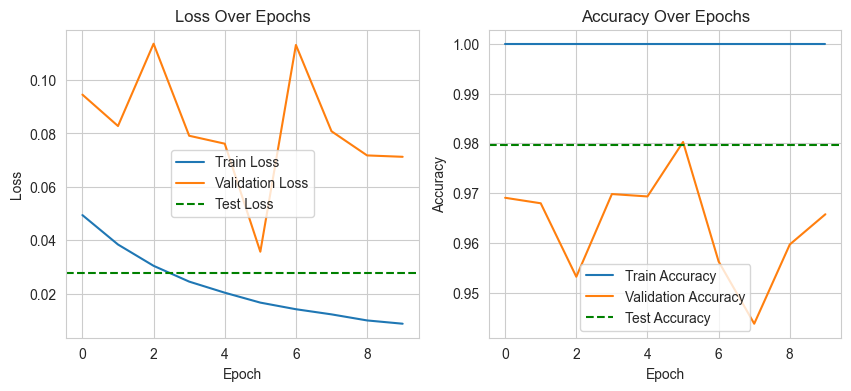

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score, precision_score, f1_score, \
    precision_recall_curve
import numpy as np

test_loss, test_accuracy = final_model.evaluate(test_ensemble_generator, steps=test_steps)
# 使用 evaluate 方法评估模型，并获取所有返回值

# 打印损失和准确率
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, label='Test Loss', color='green', linestyle='--')  # 添加测试损失
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, label='Test Accuracy', color='green', linestyle='--')  # 添加测试准确率
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
# final_model.save(r'D:\Download\MV_Coursework\Coursework\Code\model\ensemble\2.h5')

In [35]:
# Initialize data and label lists for ensemble testing
ensemble_test_images = []
ensemble_test_labels = []

# Iterate over the test data generator
for i in range(test_steps):
    (x1, x2), y = next(test_ensemble_generator)
    ensemble_test_images.append(x1)  # Assuming x1 and x2 are identical
    ensemble_test_labels.append(y)
# Convert lists to numpy arrays
ensemble_test_data = np.concatenate(ensemble_test_images)
y_true = np.concatenate(ensemble_test_labels)

# Use the combined test data for predictions with the ensemble model
y_probs = final_model.predict([ensemble_test_data, ensemble_test_data])

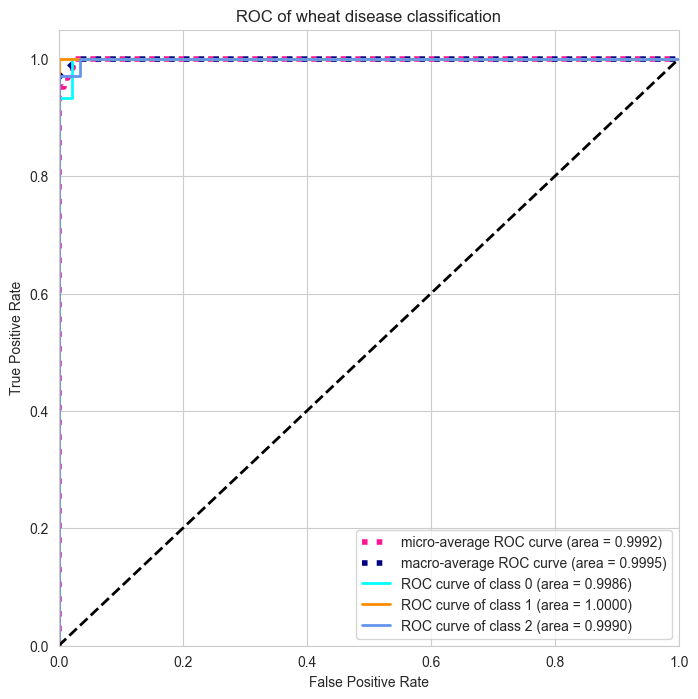

In [37]:
from itertools import cycle

# 计算每个类别的ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true.shape[1]

# 为每个类别计算FPR和TPR
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算微观平均ROC曲线和ROC面积
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 计算宏观平均ROC曲线和ROC面积
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# 插值所有ROC曲线到这些点
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# 计算平均并得出最终结果
mean_tpr /= n_classes

fpr["macro"], tpr["macro"], _ = all_fpr, mean_tpr, np.zeros_like(all_fpr)
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 绘制所有ROC曲线
plt.figure(figsize=(8, 8))

# 绘制微观平均ROC曲线
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# 绘制宏观平均ROC曲线
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# 绘制每个类别的ROC曲线
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
class_names = ["Health", "Septoria", "StipeRust"]  # 请替换成实际的类别名称

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.4f})'
                   ''.format(class_names[i], roc_auc[i]))

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of wheat disease classification')
plt.legend(loc="lower right")
plt.show()

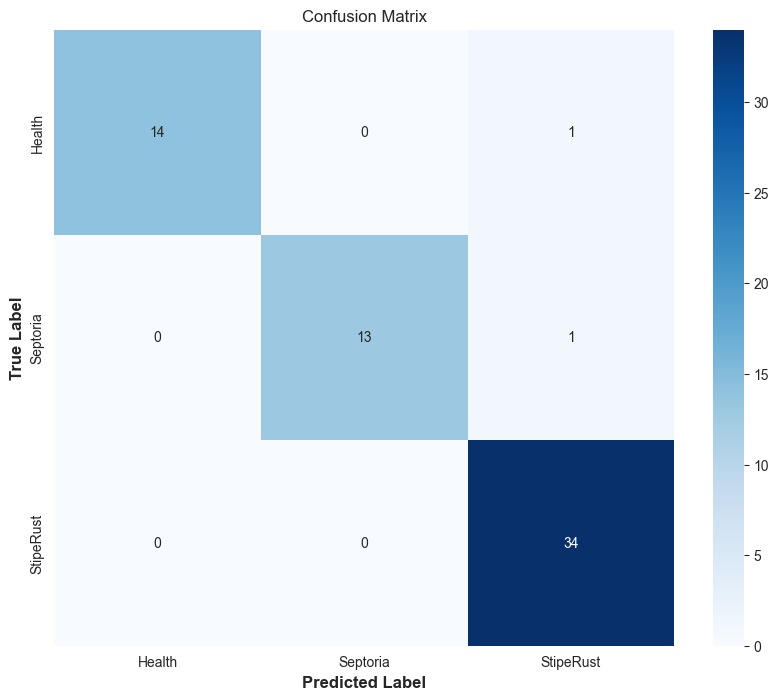

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假设这是你的类别名称列表
class_names = ["Health", "Septoria", "StipeRust"]  # 请替换成实际的类别名称

# 将概率转换为预测类别
y_pred = np.argmax(y_probs, axis=1)
y_true_classes = np.argmax(y_true, axis=1)  # 如果y_true是独热编码的，则需要转换为类别

# 计算混淆矩阵
cm = confusion_matrix(y_true_classes, y_pred)

# 使用 Seaborn 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.show()

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

recall = recall_score(y_true_classes, y_pred, average='weighted')
precision = precision_score(y_true_classes, y_pred, average='weighted')
f1 = f1_score(y_true_classes, y_pred, average='weighted')

print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Recall: 0.953968253968254
Precision: 0.9814814814814815
F1 Score: 0.9666362585902816


In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 假设 y_true_classes 和 y_pred 是你的真实标签和预测标签
cm = confusion_matrix(y_true_classes, y_pred)
n_classes = cm.shape[0]

# 计算特异性和敏感性
specificity = np.zeros(n_classes)
sensitivity = np.zeros(n_classes)
for i in range(n_classes):
    TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    FP = cm[:, i].sum() - cm[i, i]
    specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0

# 计算每个类别的权重（样本数量）
weights = cm.sum(axis=1) / cm.sum()

# 计算加权平均
weighted_specificity = np.average(specificity, weights=weights)
weighted_sensitivity = np.average(sensitivity, weights=weights)

print(f"Weighted Specificity: {weighted_specificity}")
print(f"Weighted Sensitivity: {weighted_sensitivity}")

Specificity: 0.953968253968254


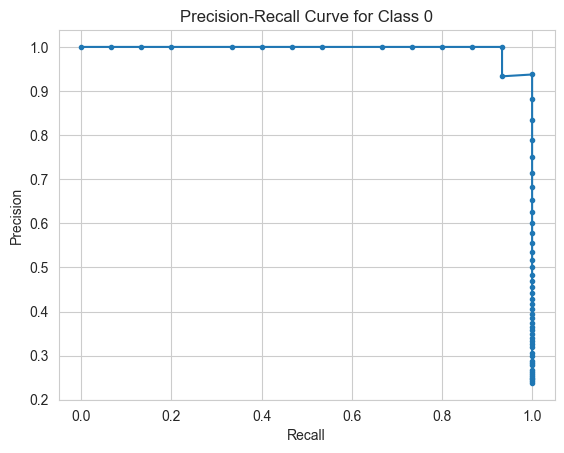

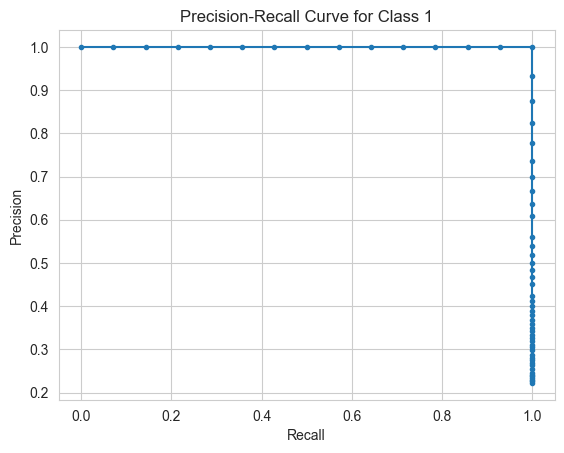

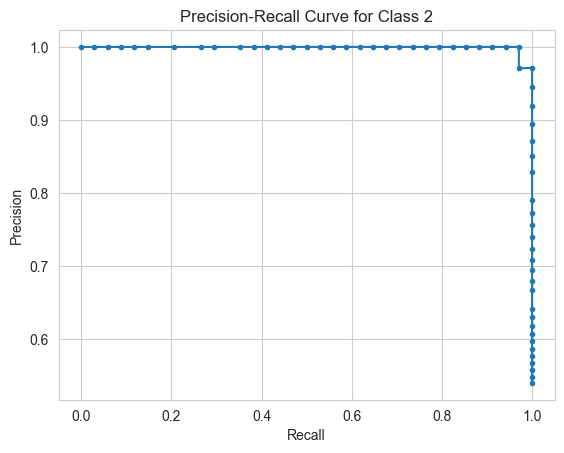

In [41]:
# 选择一个类别来绘制 precision-recall curve
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve for Class {}'.format(i))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [42]:
def mcc_score(y_true, y_pred, class_label):
    """
    Calculate Matthew Correlation Coefficient for a specific class.
    """
    cm = confusion_matrix(y_true, y_pred)

    tp = cm[class_label, class_label]
    tn = np.sum(cm) - np.sum(cm[class_label, :]) - np.sum(cm[:, class_label]) + tp
    fp = np.sum(cm[:, class_label]) - tp
    fn = np.sum(cm[class_label, :]) - tp

    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    # To avoid division by zero
    if denominator == 0:
        return 0

    return numerator / denominator

# 转换独热编码标签为类别标签
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = y_pred

# 计算每个类别的 MCC
mcc_scores = [mcc_score(y_true_classes, y_pred_classes, i) for i in range(n_classes)]

# 计算平均 MCC
average_mcc = np.mean(mcc_scores)
print(f"Average MCC: {average_mcc}")

Average MCC: 0.9492791937864787


In [ ]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()
#
del final_model